In [1]:
import pandas as pd
import seaborn as sns
import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
from mysql.connector import errorcode
from sklearn.cluster import KMeans

In [2]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
config = {
  'host':'elecsimresults2.mysql.database.azure.com',
  'user':'alexkell@elecsimresults2',
  'password':'b3rz0s4m4dr1dth3h01113s!',
  'database':'carbonoptimiser',
  'ssl_ca':'/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/validation-optimisation/database/BaltimoreCyberTrustRoot.crt.pem'
}

# conn = mysql.connector.connect(**config)


try:
    conn = mysql.connector.connect(**config)
    print("Connection established")
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with the user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor = conn.cursor()

Connection established


In [5]:
ga_results = pd.read_sql('SELECT * FROM carbon_results_function', con=conn)
ga_results['run_number'] = np.repeat([1,2],80)
ga_results

,id,average_electricity_price,carbon_emitted,attr_function,attr_m,attr_c,attr_a,attr_d,run_number
0,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1
1,2,3.455570,0.0,1.0,9.273293,222.611679,-5.329590,12.956666,1
2,3,3.544634,0.0,1.0,2.294460,170.640274,6.567950,3.051510,1
3,4,3.642749,0.0,1.0,7.827714,138.327347,-6.872702,6.064339,1
4,5,3.706068,0.0,0.0,-5.504350,28.775219,1.812898,13.146162,1
...,...,...,...,...,...,...,...,...,...
155,156,7.597517,0.0,1.0,12.691078,34.120270,-2.920261,5.126348,2
156,157,7.685183,0.0,1.0,5.809649,34.120270,-2.920261,7.170292,2
157,158,7.787386,0.0,1.0,7.150957,151.034637,7.932056,7.170292,2
158,159,8.090209,0.0,1.0,9.222916,28.845936,8.830420,1.632036,2


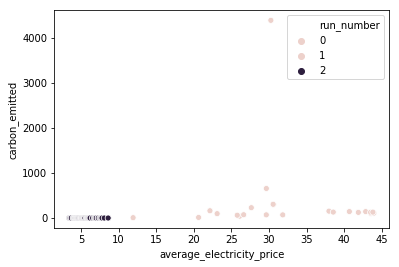

In [6]:
sns.scatterplot(data=ga_results, x='average_electricity_price',  y='carbon_emitted', hue='run_number')

In [7]:
less_than_5 = ga_results[ga_results.average_electricity_price < 5]
less_than_5.head()

,id,average_electricity_price,carbon_emitted,attr_function,attr_m,attr_c,attr_a,attr_d,run_number
0,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1
1,2,3.455570,0.0,1.0,9.273293,222.611679,-5.329590,12.956666,1
2,3,3.544634,0.0,1.0,2.294460,170.640274,6.567950,3.051510,1
3,4,3.642749,0.0,1.0,7.827714,138.327347,-6.872702,6.064339,1
4,5,3.706068,0.0,0.0,-5.504350,28.775219,1.812898,13.146162,1


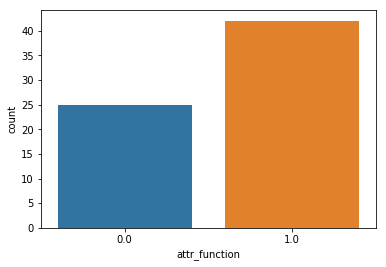

In [8]:
sns.countplot(data=less_than_5, x='attr_function')

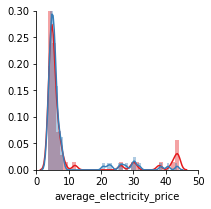

In [9]:
g = sns.FacetGrid(ga_results, hue="attr_function", palette="Set1")
g = (g.map(sns.distplot, "average_electricity_price"))
g.set(ylim=(0, 0.3), xlim=(0,50))

In [10]:
def get_linear_points(m, c, x_range_max):
    x = np.linspace(0, x_range_max, 50)
    y = m*x+c
    return x, y

def get_log_points(c, a, d, x_range_max):
    x = np.linspace(0, x_range_max, 50)
    y = a*x ** d + c
    return x, y

# def to_long_df(x, y)
    
def select_function(dat):
    if dat['attr_function'] == 1:
        return get_log_points(dat['attr_c'], dat['attr_a'], dat['attr_d'], 18)
    else:
        return get_linear_points(dat['attr_m'], dat['attr_c'], 18)

In [11]:
results_with_lines = ga_results.copy()
results_with_lines[['x','y']] = ga_results.apply(lambda x: select_function(x), axis=1, result_type='expand')
results_with_lines

,id,average_electricity_price,carbon_emitted,attr_function,attr_m,attr_c,attr_a,attr_d,run_number,x,y
0,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[238.11575317382812, 238.1155428185266, 237.83..."
1,2,3.455570,0.0,1.0,9.273293,222.611679,-5.329590,12.956666,1,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[222.61167907714844, 222.61166673091927, 222.5..."
2,3,3.544634,0.0,1.0,2.294460,170.640274,6.567950,3.051510,1,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[170.64027404785156, 170.94948593029773, 173.2..."
3,4,3.642749,0.0,1.0,7.827714,138.327347,-6.872702,6.064339,1,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[138.3273468017578, 138.3115123356989, 137.267..."
4,5,3.706068,0.0,0.0,-5.504350,28.775219,1.812898,13.146162,1,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[28.775218963623047, 26.753212773070043, 24.73..."
...,...,...,...,...,...,...,...,...,...,...,...
155,156,7.597517,0.0,1.0,12.691078,34.120270,-2.920261,5.126348,2,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[34.120269775390625, 34.103056944943134, 33.51..."
156,157,7.685183,0.0,1.0,5.809649,34.120270,-2.920261,7.170292,2,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[34.120269775390625, 34.11804701472243, 33.800..."
157,158,7.787386,0.0,1.0,7.150957,151.034637,7.932056,7.170292,2,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[151.03463745117188, 151.04067494650897, 151.9..."
158,159,8.090209,0.0,1.0,9.222916,28.845936,8.830420,1.632036,2,"[0.0, 0.3673469387755102, 0.7346938775510204, ...","[28.845935821533203, 30.56847978626164, 34.184..."


In [12]:
# results_with_lines = results_with_lines.explode('x').explode('y').drop_duplicates(subset=results_with_lines.columns[:-1])
# results_with_lines.dtypes
# results_with_lines.head()

# results_with_lines.set_index().apply(pd.Series.explode).reset_index()


def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

results_with_lines_exploded = explode(results_with_lines, ['x','y'])


In [13]:
results_with_lines_exploded

,id,average_electricity_price,carbon_emitted,attr_function,attr_m,attr_c,attr_a,attr_d,run_number,x,y
0,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,0.000000,238.115753
1,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,0.367347,238.115543
2,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,0.734694,237.836021
3,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,1.102041,219.320767
4,1,3.454978,0.0,1.0,-6.677182,238.115753,-6.857354,10.377003,1,1.469388,-133.874557
...,...,...,...,...,...,...,...,...,...,...,...
7995,160,8.604745,0.0,0.0,-9.859930,114.925339,0.000000,2.409019,2,16.530612,-48.065341
7996,160,8.604745,0.0,0.0,-9.859930,114.925339,0.000000,2.409019,2,16.897959,-51.687357
7997,160,8.604745,0.0,0.0,-9.859930,114.925339,0.000000,2.409019,2,17.265306,-55.309372
7998,160,8.604745,0.0,0.0,-9.859930,114.925339,0.000000,2.409019,2,17.632653,-58.931387


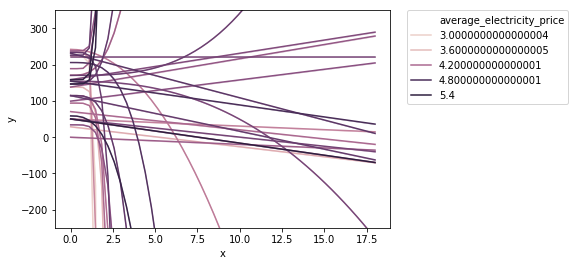

In [14]:
g = sns.lineplot(data=results_with_lines_exploded[results_with_lines_exploded.average_electricity_price<5], x='x', y='y', hue='average_electricity_price')
# g = sns.lineplot(data=results_with_lines_exploded, x='x', y='y', hue='average_electricity_price')
g.set(ylim=(-250, 350))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



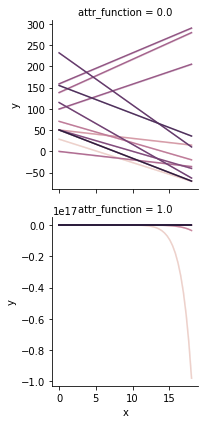

In [15]:
g = sns.FacetGrid(results_with_lines_exploded[results_with_lines_exploded.average_electricity_price<5], row='attr_function', sharey=False)
g = g.map(sns.lineplot, 'x', 'y', 'average_electricity_price')



In [42]:
# for a in range(-100,100):
#     for b in range(-100,100):
#         for c in range(0,250):
#             res = a*18**b+c
            
            
# a = np.linspace(-5,5, num = 300).tolist()
# b = np.linspace(-1,5, num = 300).tolist()
# c = np.linspace(0,250, num = 300).tolist()

a = np.linspace(1.0,2.65, num = 300).tolist()
b = np.linspace(0,1, num = 300).tolist()
c = np.linspace(0,125, num = 300).tolist()

# 1.0, 2.6505167705463295, 0.0, 1.0, 125.5667309153067

# len(np.outer(np.outer(a,b).ravel(),c).ravel())

In [17]:
# df = pd.DataFrame(np.outer(ser2, ser1), index = ser2.index, columns = ser1.index)

In [43]:
index = pd.MultiIndex.from_product([a, b, c], names = ["a", "b", "c"])

cartesian_product = pd.DataFrame(index = index).reset_index()
cartesian_product

,a,b,c
0,1.00,0.0,0.000000
1,1.00,0.0,0.418060
2,1.00,0.0,0.836120
3,1.00,0.0,1.254181
4,1.00,0.0,1.672241
...,...,...,...
26999995,2.65,1.0,123.327759
26999996,2.65,1.0,123.745819
26999997,2.65,1.0,124.163880
26999998,2.65,1.0,124.581940


In [44]:
for i in range(19):
    cartesian_product['res_{}'.format(i)] = cartesian_product['a']*i**cartesian_product['b']+cartesian_product['c']
cartesian_product

,a,b,c,res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,res_11,res_12,res_13,res_14,res_15,res_16,res_17,res_18
0,1.00,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.00,0.0,0.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060,1.418060
2,1.00,0.0,0.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120,1.836120
3,1.00,0.0,1.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181,2.254181
4,1.00,0.0,1.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241,2.672241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26999995,2.65,1.0,123.327759,123.327759,125.977759,128.627759,131.277759,133.927759,136.577759,139.227759,141.877759,144.527759,147.177759,149.827759,152.477759,155.127759,157.777759,160.427759,163.077759,165.727759,168.377759,171.027759
26999996,2.65,1.0,123.745819,123.745819,126.395819,129.045819,131.695819,134.345819,136.995819,139.645819,142.295819,144.945819,147.595819,150.245819,152.895819,155.545819,158.195819,160.845819,163.495819,166.145819,168.795819,171.445819
26999997,2.65,1.0,124.163880,124.163880,126.813880,129.463880,132.113880,134.763880,137.413880,140.063880,142.713880,145.363880,148.013880,150.663880,153.313880,155.963880,158.613880,161.263880,163.913880,166.563880,169.213880,171.863880
26999998,2.65,1.0,124.581940,124.581940,127.231940,129.881940,132.531940,135.181940,137.831940,140.481940,143.131940,145.781940,148.431940,151.081940,153.731940,156.381940,159.031940,161.681940,164.331940,166.981940,169.631940,172.281940


In [20]:
# def get_point_on_curve(dat, num):
#     results = []
#     for number in range(num):
#         res = dat['a']*number**dat['b']+dat['c']
#         results.append(res)
        
#     return pd.Series(results)
        

# cartesian_product[["res_{}".format(i) for i in range(19)]] = cartesian_product.apply(lambda x: get_point_on_curve(x, 19), axis=1)


In [45]:
query_string = " ".join(["res_{} < 250 and res_{} > 0 and".format(i,i) for i in range(19)])[:-4]

# cartesian_product.query("res_0 < 250 and res_1 < 250")
within_range = cartesian_product.query(query_string)



In [46]:
len(within_range)/len(cartesian_product)

0.9966777777777778

In [23]:
# within_range = cartesian_product[(cartesian_product.result>0) & (cartesian_product.result<250)]
# within_range

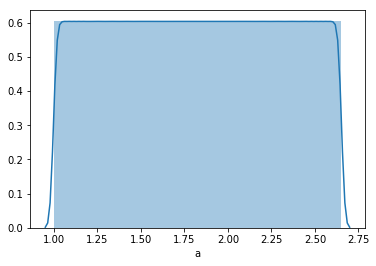

In [47]:
sns.distplot(within_range['a'])

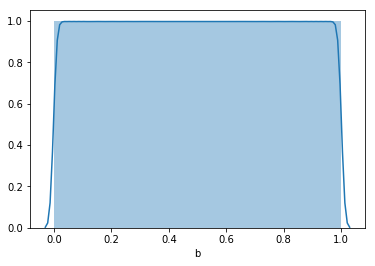

In [48]:
sns.distplot(within_range['b'])

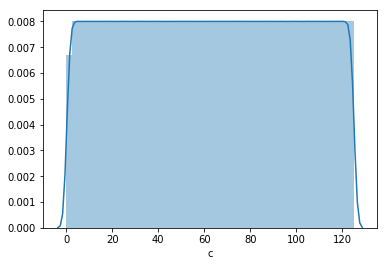

In [49]:
sns.distplot(within_range['c'])

In [36]:
def optimise_params(individual):
    a = np.linspace(individual[0],individual[1], num = 100).tolist()
    b = np.linspace(individual[2],individual[3], num = 100).tolist()
    c = np.linspace(0,individual[4], num = 100).tolist()

    index = pd.MultiIndex.from_product([a, b, c], names = ["a", "b", "c"])

    cartesian_product = pd.DataFrame(index = index).reset_index()
    cartesian_product

    for i in range(19):
        cartesian_product['res_{}'.format(i)] = cartesian_product['a']*i**cartesian_product['b']+cartesian_product['c']
    cartesian_product

    query_string = " ".join(["res_{} < 250 and res_{} > 0 and".format(i,i) for i in range(19)])[:-4]

    # cartesian_product.query("res_0 < 250 and res_1 < 250")
    within_range = cartesian_product.query(query_string)
    
    return len(within_range)/len(cartesian_product),




In [41]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_a", random.uniform, -5, 0)
toolbox.register("attr_b", random.uniform, -5, -0.1)
toolbox.register("attr_c", random.uniform, 0, 250)
toolbox.register("attr_a1", random.uniform, 0, 5)
toolbox.register("attr_b1", random.uniform, 0.1, 5)

# Structure initializers
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_a, toolbox.attr_a1, toolbox.attr_b, toolbox.attr_b1, toolbox.attr_c),n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", optimise_params)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
#     random.seed(64)
    
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof


main()

gen	nevals	avg     	std     	min     	max     
0  	50    	0.261557	0.140113	0.039263	0.674152
1  	30    	0.378186	0.151469	0.170012	0.720008
2  	33    	0.468495	0.166589	0       	0.865503
3  	29    	0.603965	0.126739	0.325917	0.865503
4  	35    	0.731757	0.0976794	0.458032	0.865503
5  	26    	0.804826	0.123639 	0.00996 	0.948213
6  	33    	0.847208	0.0387433	0.711571	0.982632
7  	35    	0.858856	0.125215 	0.009988	0.987918
8  	23    	0.901445	0.0464999	0.837264	0.987918
9  	25    	0.934374	0.0492156	0.807505	0.989867
10 	34    	0.977537	0.0224874	0.885034	0.9999  
11 	26    	0.969199	0.13726  	0.0088  	0.9999  
12 	31    	0.972508	0.137605 	0.0099  	1       
13 	21    	0.995669	0.00495777	0.987918	1       
14 	29    	0.99848 	0.00329965	0.987918	1       
15 	29    	0.999652	0.0014046 	0.99    	1       
16 	28    	0.999148	0.00267605	0.99    	1       
17 	29    	0.999974	4.38634e-05	0.9999  	1       
18 	26    	0.999598	0.0019492  	0.99    	1       
19 	38    	0.999604	0.00194009 	0.990

([array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 1.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 0.0]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 0.0]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.5667309153067]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 0.0]),
  array('d', [1.0, 2.6505167705463295, 0.0, 0.0, 125.566730915

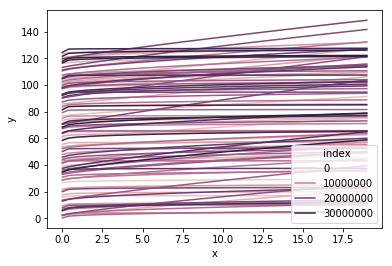

In [68]:
optimised_params = cartesian_product.sample(100).copy()
optimised_params[['x','y']]=optimised_params.apply(lambda x: get_log_points(x['c'], x['a'], x['b'],19), axis=1, result_type='expand')
optimised_params = optimised_params.reset_index()
optimised_params_exploded = explode(optimised_params, ['x','y'])
optimised_params_exploded.head()
sns.lineplot(data=optimised_params_exploded, x='x', y='y',hue='index')

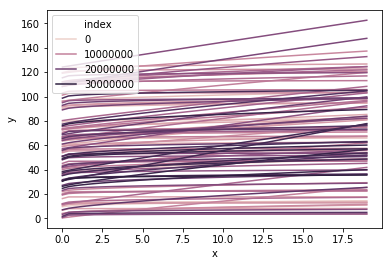